Copyright 2022 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Collapsed copyright
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# OpenSeg Demo

Golnaz Ghiasi, Xiuye Gu, Yin Cui, and Tsung-Yi Lin. 
[Scaling Open-Vocabulary Image Segmentation
with Image-Level Labels](https://arxiv.org/abs/2112.12143). 
ECCV 2022

The image tower of the OpenSeg model used in this colab has a backbone of Efficientnet-b7, initialized with the [noisy student checkpoint](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet#2-using-pretrained-efficientnet-checkpoints). The text tower is the frozen text tower of [CLIP ViT-L/14@336px](https://github.com/openai/CLIP/blob/d50d76daa670286dd6cacf3bcd80b5e4823fc8e1/clip/clip.py#L39).

The model is trained on COCO class-agnostic masks, COCO captions, and localized narrative caption data.

For faster inference speed, please use a GPU runtime. You can use your local GPU runtime or change the runtime type to "GPU" from Runtime -> Change Runtime Type in the menu.

# Preparation


In [ ]:
#@title Install dependencies
! pip install git+https://github.com/openai/CLIP.git
! pip install ipywidgets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-p1vn1pt5
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-p1vn1pt5
     |████████████████████████████████| 53 kB 1.2 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=7422eb758afe57ece6fde8d0b82a67df46c8c52ec480d9a3e7db39c7dafc3c5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ydkvt8ew/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.9 MB/s 


In [ ]:
#@title Download files 
!gsutil cp -r gs://cloud-tpu-checkpoints/detection/projects/openseg/colab/exported_model ./
!gsutil cp -r gs://cloud-tpu-checkpoints/detection/projects/openseg/colab/examples ./

Copying gs://cloud-tpu-checkpoints/detection/projects/openseg/colab/exported_model/graph_def.txt...
Copying gs://cloud-tpu-checkpoints/detection/projects/openseg/colab/exported_model/saved_model.pb...
-
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://cloud-tpu-checkpoints/detection/projects/openseg/colab/exported_model/variables/variables.data-00000-of-00001...
Copying gs://cloud-tpu-checkpoints/detection/projects/openseg/colab/exported_model/variables/variables.index...
\ [4 files][498.2 MiB/498.2 MiB]   44.6 MiB/s                                   
Operation completed over 4 objects/498.2 MiB.                                    
Copying gs://cloud-tpu-checkpoints/detection/projects/openseg/colab/examples/book.jpg...
Copying gs://cloud-tpu-checkpoints/detection/projects/o

In [ ]:
#@title Import libraries
from easydict import EasyDict

import numpy as np
import torch
import clip

from tqdm import tqdm

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import numpy as np

import os

from PIL import Image
from pprint import pprint
from scipy.special import softmax
import yaml

import tensorflow.compat.v1 as tf
import tensorflow as tf2
import ipywidgets as widgets
from google.colab import files

## Build text embeddings

We use the CLIP model from OpenAI: https://github.com/openai/CLIP.

In [ ]:
clip.available_models()
model, preprocess = clip.load("ViT-L/14@336px")


def build_text_embedding(categories):

  run_on_gpu = torch.cuda.is_available()

  with torch.no_grad():
    all_text_embeddings = []
    print("Building text embeddings...")
    for category in tqdm(categories):
      texts = clip.tokenize(category)  #tokenize
      if run_on_gpu:
        texts = texts.cuda()
      text_embeddings = model.encode_text(texts)  #embed with text encoder

      text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

      text_embedding = text_embeddings.mean(dim=0)

      text_embedding /= text_embedding.norm()

      all_text_embeddings.append(text_embedding)

    all_text_embeddings = torch.stack(all_text_embeddings, dim=1)

    if run_on_gpu:
      all_text_embeddings = all_text_embeddings.cuda()
  return all_text_embeddings.cpu().numpy().T

100%|███████████████████████████████████████| 891M/891M [00:25<00:00, 37.2MiB/s]


## Load OpenSeg model

In [ ]:
saved_model_dir = './exported_model' #@param {type:"string"}

openseg_model = tf2.saved_model.load(saved_model_dir, tags=[tf.saved_model.tag_constants.SERVING],)

## utils

In [ ]:
"""Ref: https://github.com/facebookresearch/detectron2/blob/22e04d1432363be727797a081e3e9d48981f5189/detectron2/utils/colormap.py
"""
_COLORS = np.array([
    0.000, 0.000, 0.000, 0.000, 0.447, 0.741, 0.850, 0.325, 0.098, 0.929, 0.694,
    0.125, 0.494, 0.184, 0.556, 0.466, 0.674, 0.188, 0.301, 0.745, 0.933, 0.635,
    0.078, 0.184, 0.300, 0.300, 0.300, 0.600, 0.600, 0.600, 1.000, 0.000, 0.000,
    1.000, 0.500, 0.000, 0.749, 0.749, 0.000, 0.000, 1.000, 0.000, 0.000, 0.000,
    1.000, 0.667, 0.000, 1.000, 0.333, 0.333, 0.000, 0.333, 0.667, 0.000, 0.333,
    1.000, 0.000, 0.667, 0.333, 0.000, 0.667, 0.667, 0.000, 0.667, 1.000, 0.000,
    1.000, 0.333, 0.000, 1.000, 0.667, 0.000, 1.000, 1.000, 0.000, 0.000, 0.333,
    0.500, 0.000, 0.667, 0.500, 0.000, 1.000, 0.500, 0.333, 0.000, 0.500, 0.333,
    0.333, 0.500, 0.333, 0.667, 0.500, 0.333, 1.000, 0.500, 0.667, 0.000, 0.500,
    0.667, 0.333, 0.500, 0.667, 0.667, 0.500, 0.667, 1.000, 0.500, 1.000, 0.000,
    0.500, 1.000, 0.333, 0.500, 1.000, 0.667, 0.500, 1.000, 1.000, 0.500, 0.000,
    0.333, 1.000, 0.000, 0.667, 1.000, 0.000, 1.000, 1.000, 0.333, 0.000, 1.000,
    0.333, 0.333, 1.000, 0.333, 0.667, 1.000, 0.333, 1.000, 1.000, 0.667, 0.000,
    1.000, 0.667, 0.333, 1.000, 0.667, 0.667, 1.000, 0.667, 1.000, 1.000, 1.000,
    0.000, 1.000, 1.000, 0.333, 1.000, 1.000, 0.667, 1.000, 0.333, 0.000, 0.000,
    0.500, 0.000, 0.000, 0.667, 0.000, 0.000, 0.833, 0.000, 0.000, 1.000, 0.000,
    0.000, 0.000, 0.167, 0.000, 0.000, 0.333, 0.000, 0.000, 0.500, 0.000, 0.000,
    0.667, 0.000, 0.000, 0.833, 0.000, 0.000, 1.000, 0.000, 0.000, 0.000, 0.167,
    0.000, 0.000, 0.333, 0.000, 0.000, 0.500, 0.000, 0.000, 0.667, 0.000, 0.000,
    0.833, 0.000, 0.000, 1.000, 0.000, 0.000, 0.000, 0.143, 0.143, 0.143, 0.857,
    0.857, 0.857, 1.000, 1.000, 1.000
]).astype(np.float32).reshape(-1, 3)


def create_label_colormap(max_labels_in_colormap, include_black=False):
  if include_black:
    return _COLORS[:max_labels_in_colormap]
  else:
    return _COLORS[1:max_labels_in_colormap + 1]


def label2rgb(labels, class_names, include_black=False):
  colormap = create_label_colormap(len(class_names), include_black)
  colormapped_label = colormap[labels]
  return colormapped_label


def resize_and_crop_image(image,
                          desired_size,
                          padded_size,
                          aug_scale_min=1.0,
                          aug_scale_max=1.0,
                          seed=1,
                          method=tf.image.ResizeMethod.BILINEAR,
                          logarithmic_sampling=False):
  """Resizes the input image to output size (RetinaNet style).

  Resize and pad images given the desired output size of the image and
  stride size.

  Here are the preprocessing steps.
  1. For a given image, keep its aspect ratio and rescale the image to make it
     the largest rectangle to be bounded by the rectangle specified by the
     `desired_size`.
  2. Pad the rescaled image to the padded_size.
  """
  with tf.name_scope('resize_and_crop_image'):
    image_size = tf.cast(tf.shape(image)[0:2], tf.float32)

    random_jittering = (aug_scale_min != 1.0 or aug_scale_max != 1.0)

    if random_jittering:
      if logarithmic_sampling:
        random_scale = tf.exp(
            tf.random_uniform([],
                              np.log(aug_scale_min),
                              np.log(aug_scale_max),
                              seed=seed))
      else:
        random_scale = tf.random_uniform([],
                                         aug_scale_min,
                                         aug_scale_max,
                                         seed=seed)
      scaled_size = tf.round(random_scale * desired_size)
    else:
      scaled_size = desired_size

    scale = tf.minimum(scaled_size[0] / image_size[0],
                       scaled_size[1] / image_size[1])
    scaled_size = tf.round(image_size * scale)

    # Computes 2D image_scale.
    image_scale = scaled_size / image_size

    # Selects non-zero random offset (x, y) if scaled image is larger than
    # desired_size.
    if random_jittering:
      max_offset = scaled_size - desired_size
      max_offset = tf.where(
          tf.less(max_offset, 0), tf.zeros_like(max_offset), max_offset)
      offset = max_offset * tf.random_uniform([
          2,
      ], 0, 1, seed=seed)
      offset = tf.cast(offset, tf.int32)
    else:
      offset = tf.zeros((2,), tf.int32)

    scaled_image = tf.image.resize_images(
        image, tf.cast(scaled_size, tf.int32), method=method)

    if random_jittering:
      scaled_image = scaled_image[offset[0]:offset[0] + desired_size[0],
                                  offset[1]:offset[1] + desired_size[1], :]

    output_image = tf.image.pad_to_bounding_box(scaled_image, 0, 0,
                                                padded_size[0], padded_size[1])

    image_info = tf.stack([
        image_size,
        tf.constant(desired_size, dtype=tf.float32), image_scale,
        tf.cast(offset, tf.float32)
    ])
    return output_image, image_info


def parse_user_images(contents, output_size=[640, 640]):
  """Convert jpg/png encodings to numpy images."""

  def decode_content(content):
    return tf.io.decode_jpeg(content, channels=3)

  def preprocess(im):
    im = tf.image.convert_image_dtype(im, tf.float32)
    im -= (128.0 / 255.0)
    im /= (128.0 / 255.0)
    return im

  def resize(image):
    image, image_info = resize_and_crop_image(
        image, output_size, output_size, aug_scale_min=1, aug_scale_max=1)
    return image, image_info

  with tf.Graph().as_default():
    raw_images = [decode_content(c) for c in contents]
    images = [preprocess(im) for im in raw_images]
    images_resized = []
    images_info = []
    for im in images:
      im_resized, im_info = resize(im)
      images_resized.append(im_resized)
      images_info.append(im_info)

    images_resized = tf.stack(images_resized)

    raw_images = tf.stack(raw_images)
    with tf.Session() as sess:
      return sess.run([images_resized, images_info, raw_images])


def add_space_between_figs():
  f, ax = plt.subplots()
  f.set_visible(False)
  f.set_figheight(1)


def visualize_res(results,
                  categories_names,
                  show_seg_proposals=True,
                  fontsize=25,
                  fig_size=9):
  segm_proposal = results['segm_proposal'][
      0, :crop_sz[0], :crop_sz[1], :].numpy()
  segm_prediction = results['segm_prediction'][
      0, :crop_sz[0], :crop_sz[1]].numpy()
  segm_prediction_rw = results['segm_prediction_rw'][
      0, :crop_sz[0], :crop_sz[1]].numpy()

  pixel_prediction = results['pixel_prediction'][
      0, :crop_sz[0], :crop_sz[1]].numpy().astype(int)
  pixel_pred_confidence = results['pixel_pred_confidence'][
      0, :crop_sz[0], :crop_sz[1]].numpy()
  segm_confidence_rw = results['segm_confidence_rw'][
      0, :crop_sz[0], :crop_sz[1]].numpy()
  segm_confidence = results['segm_confidence'][
      0, :crop_sz[0], :crop_sz[1]].numpy()

  categories_names_ = categories_names

  if min_confidence_score.value > 0:
    categories_names_ = ['unknown']
    categories_names_.extend(categories_names)
    segm_prediction += 1
    segm_prediction[segm_confidence < min_confidence_score.value] = 0
    segm_prediction_rw += 1
    segm_prediction_rw[segm_confidence_rw < min_confidence_score.value] = 0
    pixel_prediction += 1
    pixel_prediction[pixel_pred_confidence < min_confidence_score.value] = 0

  if show_seg_proposals:
    fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))
    plt.title('segmentation proposals', fontsize=25)
    ax.imshow(np.argmax(segm_proposal, axis=-1), cmap='jet')
    ax.axis('off')
    plt.show()
    add_space_between_figs()

  def vis_seg_(segm_prediction, title=''):
    predicted_classes, unique_indices, unique_inverse = np.unique(
        segm_prediction, return_index=True, return_inverse=True)
    unique_inverse = unique_inverse.reshape(segm_prediction.shape)
    pred_class_names = [categories_names_[i] for i in predicted_classes]

    include_black = min_confidence_score.value > 0 and np.sum(
        segm_prediction == 0) > 0

    fig, ax = plt.subplots(1, 2, figsize=(fig_size * 2, fig_size))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[1].imshow(
        label2rgb(
            unique_inverse, pred_class_names, include_black=include_black))
    ax[1].axis('off')

    # Adds legend.
    cmap = create_label_colormap(
        len(pred_class_names), include_black=include_black)
    patches = [
        mpatches.Patch(color=cmap[i], label=pred_class_names[i])
        for i in range(len(pred_class_names))
    ]
    ax[1].legend(
        handles=patches,
        bbox_to_anchor=(1.01, 1.0),
        loc='upper left',
        borderaxespad=0.,
        fontsize=fontsize)
    plt.title(title)
    plt.show()

  if vis_segm_pred_with_orig_ranking:
    vis_seg_(
        segm_prediction=segm_prediction,
        title='proposal ranked based semantic score.')
  # proposal scores are re-weighted to reduce the rank of proposals that cover
  # multiple different classes.
  vis_seg_(segm_prediction=segm_prediction_rw, title='')
  if vis_per_pixel_segm_pred.value:
    vis_seg_(segm_prediction=pixel_prediction, title='per pixel prediction')

  return segm_proposal


def plot_top_k(k, region_probs, segm_proposal, categories_names):
  segm_area = np.sum(segm_proposal, axis=(0, 1))
  for i, name in enumerate(categories_names):
    add_space_between_figs()

    indices = np.argsort(-region_probs[:, i])
    fig, ax = plt.subplots(1, k, figsize=(k * 7, 7))
    fig.suptitle(name + ' (top-{} regions)'.format(k), fontsize=50, y=1.2)
    fig.tight_layout()
    ind = 0
    for j in range(segm_proposal.shape[-1]):
      if ind >= k:
        break
      if segm_area[indices[j]] < proposals_min_area.value:
        continue
      segmented_region = segm_proposal[:, :, indices[j]:indices[j] + 1] * image
      segmented_region[segmented_region == 0] = 0.6
      ax[ind].imshow(segmented_region)
      ax[ind].set_title(
          'score:{:.2f}'.format(region_probs[indices[j], i]), fontsize=40)
      ax[ind].axis('off')
      ind += 1
    plt.show()

# Start playing

./examples/telephone_kiosk.jpg


(-0.5, 639.5, 617.5, -0.5)

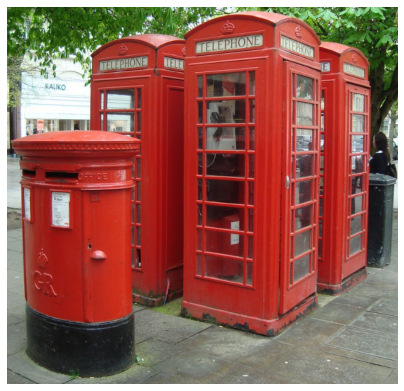

In [ ]:
#@title Upload an image or select a photo from the dir_path { run: "auto" }

upload_image = False #@param { type: "boolean", run: "auto" }
if upload_image:
  uploaded = files.upload()
  if uploaded.values():
    np_image_string = list(uploaded.values())

if not upload_image or not uploaded.values():
  dir_path = './examples/*' #@param  {type:"string", run: "auto"} 
  img_paths = tf2.io.gfile.glob(dir_path)
  image_names  = [path.split('/')[-1] for path in img_paths]
  # Default categories for demo images.
  category_dict = {
      # image source: https://www.flickr.com/photos/rusty_clark/8030932265/
      'police_car.jpg':
      'car; police car; grass; asphalt, street; sky; trees; building, buildings; fence; sign, banner; person, man, woman; sidewalk;',     
      # image source: https://www.flickr.com/photos/29233640@N07/21862750785/
      'book.jpg':
      'book; camera; drink; table; ground, tiles, floor;',
      # image source: https://www.flickr.com/photos/woolamaloo_gazette/51353517508/
      'camera.jpg':
      'camera; book; cup; snack; table; chair, chairs; sidewalk; building, house; staircase; fence; sky; sign, board; person, people;',
      # image source: https://www.flickr.com/photos/bazzadarambler/3428498261/
      'telephone_kiosk.jpg':
      'trash can; telephone kiosk; post box; sidewalk; tree; building; person, woman;',
  }

  image_name = "telephone_kiosk.jpg" #@param ["telephone_kiosk.jpg", "police_car.jpg", "camera.jpg", "book.jpg"] {type:"string"}
  img_path = 'unknown'
  for img_path_ in img_paths:
    if img_path_.endswith('/'+image_name):
      img_path = img_path_
      break
  print(img_path)
  with tf.gfile.GFile(img_path, 'rb') as f:
    np_image_string = np.array([f.read()])


images_np, images_info_np, raw_images_np = parse_user_images(np_image_string)

img_info = images_info_np[0]
crop_sz = [
    int(img_info[0, 0] * img_info[2, 0]),
    int(img_info[0, 1] * img_info[2, 1])
]

image = images_np[0, :crop_sz[0], :crop_sz[1], :]
image *= (128.0 / 255.0)
image += (128.0 / 255.0)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(image)
ax.axis('off')

In [ ]:
# @title Input form
from ipywidgets import Layout

print("For each category you can list different names. Use \';\' to separate "
      "different categories and use \',\' to separate different names of a "
      'category.')
print("E.g. \'lady, ladies, girl, girls; book\' creates two "
      "categories of \'lady or ladies or girl or girls\' and \'book\'.")
print('Categories names:')
categories_names = widgets.Textarea(
    value='sky', layout=Layout(width='50%', height='80px'))
if not upload_image and image_name in category_dict.keys():
  categories_names = widgets.Textarea(
      value=category_dict[image_name],
      description='',
      layout=Layout(width='50%', height='80px'))
display(categories_names)
print('_' * 80)
print('\nSetting confidence score:')
print('Regions with confidence score less than threshold will be '
      'assigned to unknown.')
min_confidence_score = widgets.FloatSlider(
    value=0.04,
    min=0.01,
    max=0.5,
    step=0.01,
    description='threshold:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.3f')
display(min_confidence_score)

vis_per_pixel_segm_pred = widgets.Checkbox(
    value=False,
    description='show per peixel segmentation prediction',
    disabled=False,
    indent=False)
print('_' * 80)

display(vis_per_pixel_segm_pred)

print('_' * 80)
vis_top_k = widgets.Checkbox(
    value=False,
    description='Show top_k proposals for each category',
    disabled=False,
    indent=False)
k = widgets.IntSlider(
    value=5,
    min=2,
    max=20,
    step=1,
    description='k:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d')
display(vis_top_k)
display(k)

print('Proposal min area (for visualization purpose only):')
proposals_min_area = widgets.IntSlider(
    value=2000,
    min=0,
    max=10000,
    step=500,
    description='min area:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d')
display(proposals_min_area)
legend_font_size = 18
vis_proposals = False
vis_segm_pred_with_orig_ranking = False


def run_openseg(categories_names):
  print(categories_names)
  from IPython.display import clear_output
  clear_output()
  categories_names = [x.strip() for x in categories_names.value.split(';')]
  categories_names = [cn for cn in categories_names if cn]
  max_names = 0

  for category_names in categories_names:
    category_names = category_names.split(',')
    if len(category_names) > max_names:
      max_names = len(category_names)

  all_categories_names = []
  for category_names in categories_names:
    category_names = category_names.split(',')
    while len(category_names) < max_names:
      category_names.append(category_names[0])
    all_categories_names.extend(category_names)

  text_embedding = build_text_embedding(all_categories_names)
  num_words_per_category = max_names
  # Reshapes text embeddings to [num_words, num_words_per_cat, embedding_size]
  text_embedding = tf.reshape(
      text_embedding, [-1, num_words_per_category, text_embedding.shape[-1]])
  text_embedding = tf.cast(text_embedding, tf.float32)
  print(text_embedding.shape)
  output = openseg_model.signatures['serving_default'](
      inp_image_bytes=tf.convert_to_tensor(np_image_string[0]),
      inp_text_emb=text_embedding)

  segm_proposal = visualize_res(
      output,
      categories_names=categories_names,
      show_seg_proposals=vis_proposals,
      fontsize=legend_font_size,
      fig_size=12)

  if vis_top_k.value:
    plot_top_k(
        k=k.value,
        region_probs=output['region_probs_'][0],
        segm_proposal=segm_proposal,
        categories_names=categories_names)

For each category you can list different names. Use ';' to separate different categories and use ',' to separate different names of a category.
E.g. 'lady, ladies, girl, girls; book' creates two categories of 'lady or ladies or girl or girls' and 'book'.
Categories names:


Textarea(value='trash can; telephone kiosk; post box; sidewalk; tree; building; person, woman;', layout=Layout…

________________________________________________________________________________

Setting confidence score:
Regions with confidence score less than threshold will be assigned to unknown.


FloatSlider(value=0.04, description='threshold:', max=0.5, min=0.01, readout_format='.3f', step=0.01)

________________________________________________________________________________


Checkbox(value=False, description='show per peixel segmentation prediction', indent=False)

________________________________________________________________________________


Checkbox(value=False, description='Show top_k proposals for each category', indent=False)

IntSlider(value=5, description='k:', max=20, min=2)

Proposal min area (for visualization purpose only):


IntSlider(value=2000, description='min area:', max=10000, step=500)

Building text embeddings...


100%|██████████| 14/14 [00:05<00:00,  2.57it/s]


(7, 2, 768)


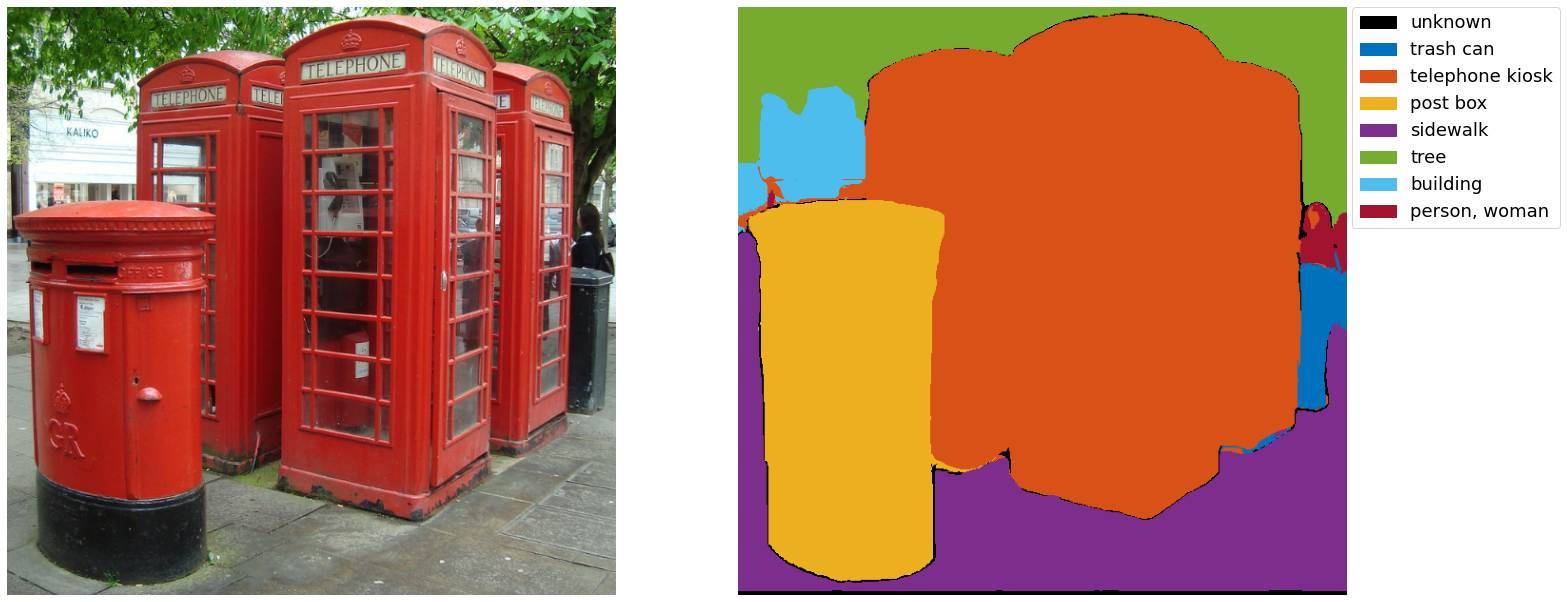

In [ ]:
# @title Run OpenSeg
run_openseg(categories_names)